# Validation of the method for estimating CH4 climate impacts related to NOx emissions

The purpose of this notebook is to validate the method for estimating NOx-related CH4 impacts by comparing the results with historical data.

In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Climate functions
from aerocm.utils.functions import emission_profile_function
from aerocm.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerocm.climate_models.gwpstar_climate_model import GWPStarClimateModel
from aerocm.climate_models.lwe_climate_model import LWEClimateModel
from aerocm.climate_models.fair_climate_model import FairClimateModel

## Reference data

In [2]:
erf_nox_lee_data_df = read_csv("../climate_data/erf_nox_lee.csv", delimiter=";")
erf_nox_lee_data = erf_nox_lee_data_df.values
data_years = erf_nox_lee_data[:, 0]
data_nox_o3 = erf_nox_lee_data[:, 1]
data_nox_ch4_direct = erf_nox_lee_data[:, 2]
data_nox_ch4_o3 = erf_nox_lee_data[:, 3]
data_nox_ch4_swv = erf_nox_lee_data[:, 4]
data_nox_ch4 = data_nox_ch4_direct + data_nox_ch4_o3 + data_nox_ch4_swv
data_nox_o3_aeromaps = erf_nox_lee_data[:, 5]
data_nox_ch4_direct_aeromaps = erf_nox_lee_data[:, 6]
data_nox_ch4_o3_aeromaps = erf_nox_lee_data[:, 7]
data_nox_ch4_swv_aeromaps = erf_nox_lee_data[:, 8]
data_nox_ch4_aeromaps = data_nox_ch4_direct_aeromaps + data_nox_ch4_o3_aeromaps + data_nox_ch4_swv_aeromaps

In [3]:
klower_data_df = read_csv("../climate_data/historical_data_from_klower.csv", delimiter=";")
klower_data = klower_data_df.values
klower_data_years = klower_data[:, 0]
klower_data_co2 = klower_data[:, 1]
klower_data_distance = klower_data[:, 2]
aeromaps_data_co2 = klower_data[:, 3]

years_total = np.zeros(2050-1940+1)
for k in range(0, 2018-1940+1):
    years_total[k] = klower_data_years[k]
for k in range(2018-1940+1, len(years_total)):
    years_total[k] = years_total[k-1] + 1

species_inventory = np.zeros(2050-1940+1)
emission_index_nox = 0.01514
for k in range(0, 2018-1940+1):
    species_inventory[k] = klower_data_co2[k] / 3.15 * emission_index_nox * 1e9 # [MtNOx to kgNOx]
for k in range(2018-1940+1, len(years_total)):
    species_inventory[k] = 0

## Parameters

In [4]:
unit_value_o3 = 1.0
sensitivity_rf_o3 = 25.1e-12 * (14/46)
ratio_erf_rf_o3 = 1.37
efficacy_erf_o3 = 1.0

unit_value_ch4 = 1.0
ch4_loss_per_nox = -3.90 # Calibration
sensitivity_rf_ch4_gwpstar = -26.1e-12 * (14/46) * 0.77 # Mean value for transcient coefficient from Lee et al.
ratio_erf_rf_ch4 = 1.18
efficacy_erf_ch4 = 1.0

start_year = 1940
end_year = 2050
tcre = 0.00045

species_settings_o3 = {"sensitivity_rf": sensitivity_rf_o3, "ratio_erf_rf": ratio_erf_rf_o3, "efficacy_erf": efficacy_erf_o3}
species_settings_ch4 = {"ch4_loss_per_nox": ch4_loss_per_nox, "ratio_erf_rf": ratio_erf_rf_ch4, "efficacy_erf": efficacy_erf_ch4}
species_settings_ch4_gwpstar = {"sensitivity_rf": sensitivity_rf_ch4_gwpstar, "ratio_erf_rf": ratio_erf_rf_ch4, "efficacy_erf": efficacy_erf_ch4}
model_settings = {"tcre": tcre}
model_settings_fair = {"rcp": "RCP45"}

## Metrics calculation

In [5]:
results_o3_gwpstar = GWPStarClimateModel(
    start_year,
    end_year,
    "NOx - ST O3 increase",
    species_inventory,
    species_settings_o3,
    model_settings
).run()

results_o3_lwe = LWEClimateModel(
    start_year,
    end_year,
    "NOx - ST O3 increase",
    species_inventory,
    species_settings_o3,
    model_settings
).run()

results_o3_fair = FairClimateModel(
    start_year,
    end_year,
    "NOx - ST O3 increase",
    species_inventory,
    species_settings_o3,
    model_settings_fair
).run()

results_ch4_gwpstar = GWPStarClimateModel(
    start_year,
    end_year,
    "NOx - CH4 decrease and induced",
    species_inventory,
    species_settings_ch4_gwpstar,
    model_settings
).run()

results_ch4_lwe = LWEClimateModel(
    start_year,
    end_year,
    "NOx - CH4 decrease and induced",
    species_inventory,
    species_settings_ch4,
    model_settings
).run()

results_ch4_fair = FairClimateModel(
    start_year,
    end_year,
    "NOx - CH4 decrease and induced",
    species_inventory,
    species_settings_ch4,
    model_settings_fair
).run()

In [6]:
radiative_forcing_o3_gwpstar = results_o3_gwpstar["radiative_forcing"]
effective_radiative_forcing_o3_gwpstar = results_o3_gwpstar["effective_radiative_forcing"]
temperature_o3_gwpstar = results_o3_gwpstar["temperature"]
radiative_forcing_o3_lwe = results_o3_lwe["radiative_forcing"]
effective_radiative_forcing_o3_lwe = results_o3_lwe["effective_radiative_forcing"]
temperature_o3_lwe = results_o3_lwe["temperature"]
radiative_forcing_o3_fair = results_o3_fair["radiative_forcing"]
effective_radiative_forcing_o3_fair = results_o3_fair["effective_radiative_forcing"]
temperature_o3_fair = results_o3_fair["temperature"]
radiative_forcing_ch4_gwpstar = results_ch4_gwpstar["radiative_forcing"]
effective_radiative_forcing_ch4_gwpstar = results_ch4_gwpstar["effective_radiative_forcing"]
temperature_ch4_gwpstar = results_ch4_gwpstar["temperature"]
radiative_forcing_ch4_lwe = results_ch4_lwe["radiative_forcing"]
effective_radiative_forcing_ch4_lwe = results_ch4_lwe["effective_radiative_forcing"]
temperature_ch4_lwe = results_ch4_lwe["temperature"]
radiative_forcing_ch4_fair = results_ch4_fair["radiative_forcing"]
effective_radiative_forcing_ch4_fair = results_ch4_fair["effective_radiative_forcing"]
temperature_ch4_fair = results_ch4_fair["temperature"]

## Plot comparisons

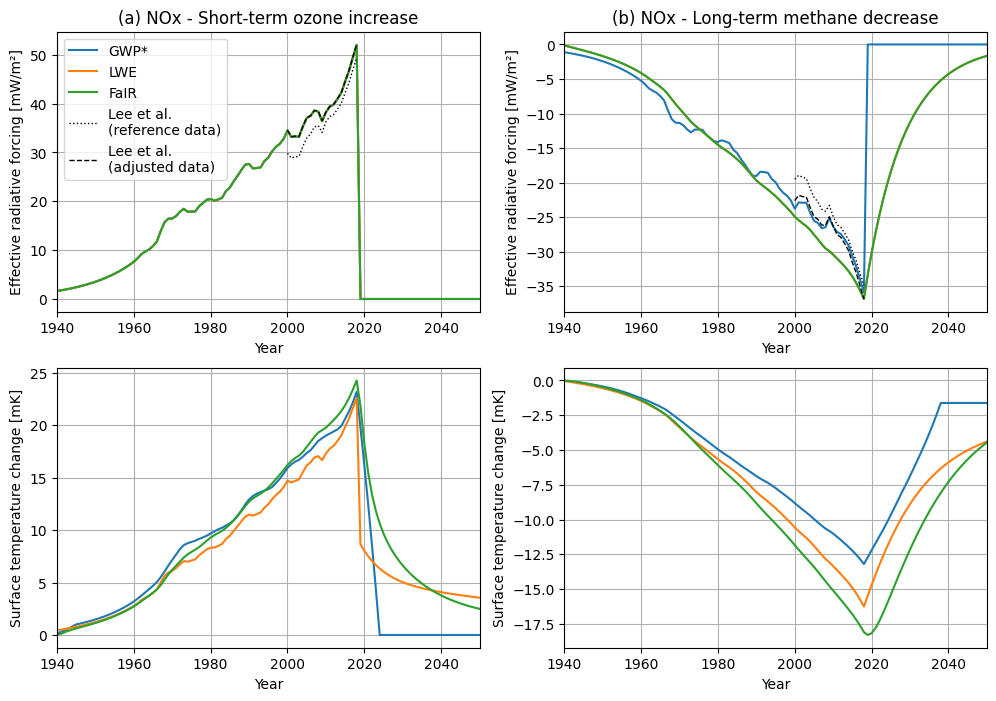

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(years_total, 1000 * effective_radiative_forcing_o3_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * effective_radiative_forcing_o3_lwe, label='LWE')
        ax.plot(years_total, 1000 * effective_radiative_forcing_o3_fair, label='FaIR')
        ax.plot(data_years, data_nox_o3, label='Lee et al.\n(reference data)', color='black', linestyle=":", linewidth=1)
        ax.plot(data_years, data_nox_o3_aeromaps, label='Lee et al.\n(adjusted data)', color='black', linestyle="--", linewidth=1)
        ax.set_ylabel('Effective radiative forcing [mW/m²]')
        ax.legend()
    elif i == 1:
        ax.plot(years_total, 1000 * effective_radiative_forcing_ch4_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * effective_radiative_forcing_ch4_lwe, label='LWE')
        ax.plot(years_total, 1000 * effective_radiative_forcing_ch4_fair, label='FaIR')
        ax.plot(data_years, data_nox_ch4, label='Lee et al.', color='black', linestyle=":", linewidth=1)
        ax.plot(data_years, data_nox_ch4_aeromaps, label='Lee et al.\n(adjusted data)', color='black', linestyle="--", linewidth=1)
        ax.set_ylabel('Effective radiative forcing [mW/m²]')
    elif i == 2:
        ax.plot(years_total, 1000 * temperature_o3_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * temperature_o3_lwe, label='LWE')
        ax.plot(years_total, 1000 * temperature_o3_fair, label='FaIR')
        ax.set_ylabel('Surface temperature change [mK]')
    else:
        ax.plot(years_total, 1000 * temperature_ch4_gwpstar, label='GWP*')
        ax.plot(years_total, 1000 * temperature_ch4_lwe, label='LWE')
        ax.plot(years_total, 1000 * temperature_ch4_fair, label='FaIR')
        ax.set_ylabel('Surface temperature change [mK]')
    ax.set_xlim(start_year, end_year)
    ax.set_xlabel('Year')
    
    ax.grid(True)
    if i == 0:
        ax.set_title('(a) NOx - Short-term ozone increase')
    elif i == 1:
        ax.set_title('(b) NOx - Long-term methane decrease')

plt.savefig("figures/nox_validation.pdf")
plt.show()